In [1]:
import numpy as np
import matplotlib.pyplot as plt
import numba
from numba import jit
import scipy.optimize as spopt
from scipy.optimize import curve_fit

In [23]:
@numba.jit(nopython=True)

def gillespie_numba(a0,l0,m0,tf,tsteps,tchange,cnew,
                      E0=3,delta_f=-2,taul=0.001,Ki=18,Ka=2900,N=6,kR=0.1,kB=0.2,mMax=24,kAct=10**2,
                       methylation=True,ligand=True,activation=True):
    '''
    Returns an array of the activity, number of ligands bound and methylation level
    for a rate-based MWC model including (de)activation, ligand (un)binding and
    (de)methylation, implemented using Gillespie's direct algorithm and Numba
    
    Parameters
    ----------
    a0: float
        initial activity
    l0: float
        initial number of ligands bound
    m0: float
        initial methylation level
    tf: float
        final time of simulation in sec
    tsteps: int
        number of evenly-spaced time steps
    tchange: float
        time in sec at which the concentration is changed
    cnew: float
        new concentration in micromolar
    E0: float
        free energy of unmethylated active cluster in units of kT
    delta_f: float
        energy penalty per methylated site in units of kT
    taul: float
        ligand (un)binding time scale
    Ki: float
        dissocation constant for inactive cluster in micromolar
    Ka: float
        dissociation constant for active cluster in micromolar
    N: int
        number of receptors per cluster
    kR: float
        methylation rate per sec
    kB: float
        demethylation rate per sec
    mMax: int
        number of methylation sites (note: mMax = 4*N)
    kAct: float
        activation rate per sec
    methylation: bool
        boolean for whether methylation is taken into account
    ligand: bool
        boolean for whether ligand (un)binding is taken into account
    activation: bool
        boolean for whether (de)activation is taken into account
        
    Returns
    -------
    av_states: NumPy array
        array of activity, number of ligands bound and methylation level, averaged between
        the time steps given in time_regular
    '''

    regular_time = np.linspace(0,tf,num=tsteps)
    # set the initial state
    state = np.array([a0,l0,m0],dtype='float64')
    all_states = state
    
    time = 0
    c = 100
        
    # set rate constant for ligand binding
    kplus = 1/(taul*(c + Ki))
    recorded_times = np.array([0.])
    
    for j in range(tsteps-1):
        # set the events with the corresponding rates
        rates = np.zeros(4)
        events = np.zeros((4,3))

        # change concentration after tchange
        if time > tchange:
            c = cnew

        # calculate free-energy difference
        f = E0 + state[1]*np.log(Ka/Ki) + delta_f*state[2]

        # set rate constants for (de)activation
        kDeact = kAct*np.exp(f)

        # check methylation states
        meth_ceiling = state[2] < mMax
        meth_floor = state[2] > 0

        # for inactive cluster
        if state[0] == 0:
            # ligand binding
            rates[0] = kplus*c*(N - state[1])*ligand
            events[0] = [0,1,0]

            # ligand unbinding
            rates[1] = kplus*Ki*state[1]*ligand
            events[1] = [0,-1,0]

            # methylation; only possible if a site is available
            rates[2] = kR*meth_ceiling*methylation
            events[2] = [0,0,1]

            # activity switching
            rates[3] = kAct*activation
            events[3] = [1,0,0]

        # for active cluster
        else:
            # ligand binding
            rates[0] = kplus*c*(N - state[1])*ligand
            events[0] = [0,1,0]

            # ligand unbinding
            rates[1] = kplus*Ka*state[1]*ligand
            events[1] = [0,-1,0]

            # demethylation; only possible if a site is occupied
            rates[2] = kB*meth_floor*methylation
            events[2] = [0,0,-1]

            # deactivation
            rates[3] = kDeact*activation
            events[3] = [-1,0,0]

        # determine which event occurs
        p = np.random.uniform(0,1)*np.sum(rates)
        mask = p < np.cumsum(rates)
        event_idx = np.where(mask == True)[0][0]
        
        # this samples the time until the next event
        u = np.random.uniform(0,1)
        dt = -np.log(u)/np.sum(rates)
        
        # perform event if sampled time sooner than regular
        if time + dt < regular_time[j+1]:
            state = state + events[event_idx]
            time += dt
        # otherwise don't perform any event and skip to next regular time
        else:
            time = regular_time[j+1]
        
        recorded_times = np.append(recorded_times, time)
        
        all_states = np.append(all_states,state)
    
    # reshape into a 2d array
    results = np.reshape(all_states,(all_states.size//3,3))
    
    # normalise the results
    results[:,1] = results[:,1]/N
    results[:,2] = results[:,2]/mMax
                                    
    return results, recorded_times

In [24]:
a0 = 1
l0 = 2
m0 = 10
tf = 10
tsteps = 3500
tchange = 100
cnew = 100
n_sims = 10**3

# array to store results; first index is the realisation, second is time
# third specifies the variable (e.g., activity)
all_sims = np.empty((n_sims, tsteps, 3))
all_times = np.empty((n_sims, tsteps))

for i in range(n_sims):
    all_sims[i,:,:], all_times[i,:] = gillespie_numba(a0,l0,m0,tf,tsteps,tchange,cnew,ligand=False)

The average time step is 0.0028578956214436353


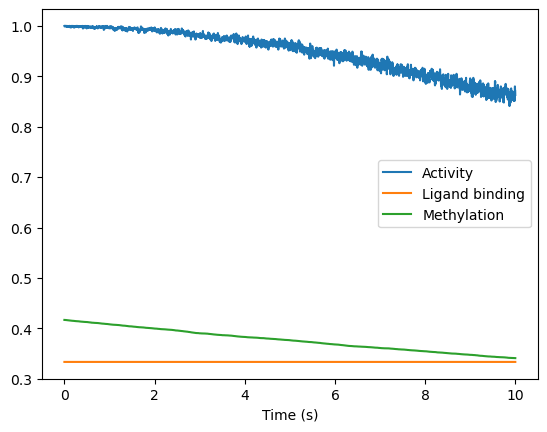

In [25]:
# this is dodgy; I'm going to average the time steps now
av_time = np.mean(all_times, axis=0)
print('The average time step is', np.mean(np.diff(av_time)))

plt.plot(av_time,np.mean(all_sims[:,:,0], axis=0),label='Activity')
plt.plot(av_time,np.mean(all_sims[:,:,1], axis=0),label='Ligand binding')
plt.plot(av_time,np.mean(all_sims[:,:,2], axis=0),label='Methylation')
plt.legend()
plt.xlabel('Time (s)')
plt.show()

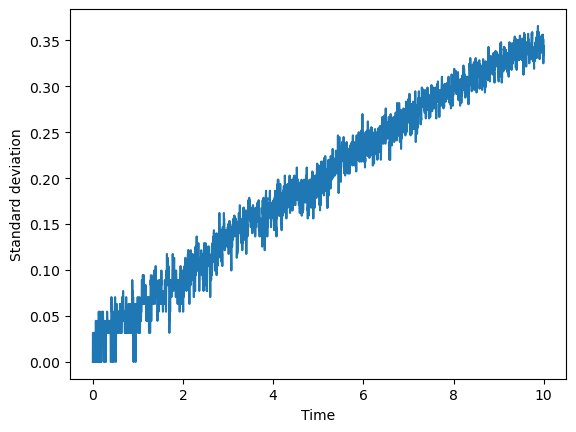

In [26]:
plt.plot(av_time, np.std(all_sims[:,:,0],axis=0))
plt.ylabel('Standard deviation')
plt.xlabel('Time')
plt.show()

Parameters of best fit for activity: [B, tau, alpha] = [  5299.17716072 364411.6554452   -5298.1567786 ]
Time scale of activation is 364411.6554451955 s


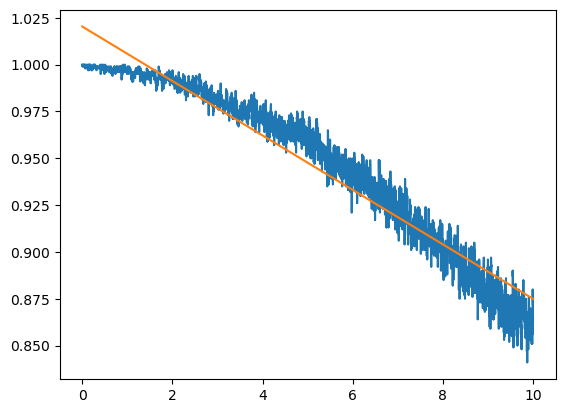

RuntimeError: Optimal parameters not found: Number of calls to function has reached maxfev = 800.

In [27]:
# playing around with some fitting
activity = np.mean(all_sims[:,:,0], axis=0)
ligand_binding = np.mean(all_sims[:,:,1], axis=0)

# define model function
def exp_fit(t,B,tau,alpha):
    return B*np.exp(-t/tau) + alpha

# perform fitting
popt, pcov = curve_fit(exp_fit,av_time,activity)
print('Parameters of best fit for activity: [B, tau, alpha] =',popt)
print('Time scale of activation is', popt[1],'s')

plt.plot(av_time,activity)
plt.plot(av_time,exp_fit(av_time,*popt))
plt.show()

# perform fitting
popt, pcov = curve_fit(exp_fit,av_time,ligand_binding)
print('Parameters of best fit for ligand binding: [B, tau, alpha] =',popt)
print('Time scale of ligand binding is', popt[1],'s')

plt.plot(av_time,ligand_binding)
plt.plot(av_time,exp_fit(av_time,*popt))
plt.show()